In [1]:
%matplotlib inline

from __future__ import print_function
from scipy.optimize import curve_fit

from astropy.io import ascii
from astropy.table import Table

import matplotlib.pyplot as plt
import numpy as np
import math
from pylab import figure, text, scatter, show

#import astropy.io.fits as pyfits
import pyfits, time, itertools, random, os, sys, glob, re

import scipy.odr
from scipy.stats import pearsonr

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

import scipy.stats as stats
import statsmodels.api as sm
#import seaborn as sns; sns.set()

/Users/katiemel/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/katiemel/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
star_names = np.genfromtxt("star_names.txt", dtype='str')

uv_lines = ["CII", "CIV", "HeII",  "NV", "SiIII", "SiII", "SiIV", "LyA", "MgII"]#, "EUV" # "MgII",]"LyA",
optical_indicators = ["s", "rhk_prime", "H_alpha"]
#optical_indicators = ["s", "rhk_prime"]

data = ascii.read("ALL_DATA.dat", fill_values=[("nan", 0.0)]) 
print(data.dtype.names)

def linear_regression(B, x):
    y = B[0] * x  + B[1]
    return y

('star', 'RV', 'K', 'err_K', 'V', 'err_V', 'H_alpha', 'H_alpha_err', 's', 's_err', 'rhk_prime', 'rhk_prime_err', 'log_s', 'log_s_err', 'log_rhk_prime', 'log_rhk_prime_err', 'SiIII', 'SiIII_err', 'LyA', 'LyA_err', 'SiII', 'SiII_err', 'CII', 'CII_err', 'MgII', 'MgII_err', 'SiIV', 'SiIV_err', 'HeII', 'HeII_err', 'CIV', 'CIV_err', 'NV', 'NV_err', 'EUV', 'dist', 'radius', 'teff', 'newt_Ha', 'newt_Ha_err', 'ad_logRHK', 'ad_logRHK_err', 'ad_S', 'ad_S_err', 'num_spectra_ha', 'num_spectra_s', 'num_spectra_logrhk', 'SiIII_lum', 'SiIII_surface_flux', 'SiIII_lum_err', 'SiIII_surface_flux_err', 'LyA_lum', 'LyA_surface_flux', 'LyA_lum_err', 'LyA_surface_flux_err', 'SiII_lum', 'SiII_surface_flux', 'SiII_lum_err', 'SiII_surface_flux_err', 'CII_lum', 'CII_surface_flux', 'CII_lum_err', 'CII_surface_flux_err', 'MgII_lum', 'MgII_surface_flux', 'MgII_lum_err', 'MgII_surface_flux_err', 'SiIV_lum', 'SiIV_surface_flux', 'SiIV_lum_err', 'SiIV_surface_flux_err', 'HeII_lum', 'HeII_surface_flux', 'HeII_lum_err', 

In [12]:
#bool_array = np.logical_and(data['s'] != 0.0, data['EUV'] != 0)
#print(data)
#data_short = data[bool_array]
#print(data_short)
#data_sorted = data[np.argsort(data["s"])]
#print(data['star'])
#print(data_sorted['star'])
#print(data["H_alpha"], data["RV"])

## One plot test

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(10, 14), facecolor='w', edgecolor='k', sharex=True)

axs = axs.ravel()

#stars = np.vectorize(star_names)
    
for i in range(len(uv_lines)):
    bool_array = np.logical_and(data['s'] != 0.0, data['%s_lum' % uv_lines[i]] != 0)
    
    data_short = data[bool_array]
    data_short_sorted = data_short[np.argsort(data_short["s"])]
    
    x = np.log10(data_short_sorted['s'])
    y = np.log10(data_short_sorted['%s_lum' % uv_lines[i]])
    
    #axs[i].set_axis_off()
    im = axs[i].scatter(x, y, marker='o', s=100, c=data_short_sorted["teff"], cmap='RdBu') #s=300*data_short_sorted["radius"], 
    
    axs[i].text(np.min(x)-0.03, np.max(y)+.1, uv_lines[i])
    axs[i].set_xlim(np.min(x)-0.05,np.max(x)+0.05)
    axs[i].set_ylim(np.min(y)-0.3, np.max(y)+0.3)
    
    #for j, txt in enumerate(data_short_sorted["star"]):
        #axs[i].annotate(txt, xy=(x[j]+.01,y[j]+.05))
    
    #ERROR ANALYSIS
    x_err = np.sqrt((data_short_sorted['s_err'])**2 * (np.log10(math.e) / data_short_sorted['s'])**2)
    y_err = np.sqrt((data_short_sorted['%s_lum_err' % uv_lines[i]])**2 * (np.log10(math.e) / data_short_sorted['%s_lum' % uv_lines[i]])**2)
    axs[i].errorbar(np.log10(data_short_sorted['s']), np.log10(data_short_sorted['%s_lum' % uv_lines[i]]), 
                    xerr=x_err, yerr=y_err, linestyle="None", c="darkgrey")

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([1,0.00,0.02,1])
cbar = fig.colorbar(im, cax=cb_ax)

fig.text(0.5, -0.02, '$log_{10}$Ca II S Index', ha='center', va='center', fontsize=18)
fig.text(-0.02, 0.5, '$log_{10}$Luminosity (erg s$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=18)
fig.text(1.08, 0.5, 'Stellar Effective Temperature (K)', ha='center', va='center', rotation='vertical', fontsize=18)
#fig.colorbar(sc)
#plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.tight_layout()
#plt.savefig("s_vs_lum.png")
plt.show()

## Luminosity plots

In [ ]:
x_labels = ["Ca II S Index", "Ca II R'HK Index", "H alpha Equivalent Width"]

for k in range(len(optical_indicators)):
    data_sorted = data[np.argsort(data["%s" % optical_indicators[k]])]
    #print(data_sorted["SiIII_lum"])
    
    fig, axs = plt.subplots(5,2, figsize=(10, 14), facecolor='w', edgecolor='k', sharex=True)

    axs = axs.ravel()

    #stars = np.vectorize(star_names)

    for i in range(len(uv_lines)):
        bool_array = np.logical_and(data_sorted['%s' % optical_indicators[k]] != 0.0, data_sorted['%s_lum' % uv_lines[i]] != 0)
    
        data_short_sorted = data_sorted[bool_array]
        
        if optical_indicators[k]!="H_alpha":
            x = np.log10(data_short_sorted[optical_indicators[k]])
            y = np.log10(data_short_sorted['%s_lum' % uv_lines[i]])
        else:
            x = data_short_sorted[optical_indicators[k]]
            y = np.log10(data_short_sorted['%s_lum' % uv_lines[i]])
        
        #print(data_short_sorted["star"],data_short_sorted["H_alpha"],data_short_sorted["SiIII_lum"])

        #axs[i].set_axis_off()
        im = axs[i].scatter(x, y, marker='o', s=200*data_short_sorted['radius'], c=data_short_sorted['teff'], cmap='RdBu')

        axs[i].text(np.min(x)-0.03, np.max(y)+.1, uv_lines[i])
        axs[i].set_xlim(np.min(x)-0.05,np.max(x)+0.05)
        axs[i].set_ylim(np.min(y)-0.3, np.max(y)+0.3)

        for j, txt in enumerate(data_short_sorted['star']):
            axs[i].annotate(txt, xy=(x[j]+.01,y[j]+.05))

        #axs[i].text(0, 1, uv_lines[i], fontsize=8)
        #axs[i].errorbar(np.log10(data['s']), np.log10(data['%s_lum' % uv_lines[i]]), xerr = data['s_err'], linestyle="None")

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)

    cb_ax = fig.add_axes([1,0.00,0.02,1])
    cbar = fig.colorbar(im, cax=cb_ax)

    if optical_indicators[k]!="H_alpha":
        fig.text(0.5, -0.02, '$log_{10}$%s' % x_labels[k], ha='center', va='center', fontsize=18)
        fig.text(-0.02, 0.5, '$log_{10}$Luminosity (erg s$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=18)
        fig.text(1.08, 0.5, 'Stellar Effective Temperature (K)', ha='center', va='center', rotation='vertical', fontsize=18)
        #fig.colorbar(sc)
        #plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=None, hspace=None)
        fig.tight_layout()
        #plt.savefig("Graphs/%s_vs_lum.png" % (optical_indicators[k]), bbox_inches="tight")
        #plt.show()
    else:
        fig.text(0.5, -0.02, '%s' % x_labels[k], ha='center', va='center', fontsize=18)
        fig.text(-0.02, 0.5, '$log_{10}$Luminosity (erg s$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=18)
        fig.text(1.08, 0.5, 'Stellar Effective Temperature (K)', ha='center', va='center', rotation='vertical', fontsize=18)
        #fig.colorbar(sc)
        #plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=None, hspace=None)
        fig.tight_layout()
        plt.savefig("Graphs/%s_vs_lum.png" % (optical_indicators[k]), bbox_inches="tight")
        #plt.show()

## Surface Flux Plots

In [ ]:
x_labels = ["Ca II S Index", "Ca II R'HK Index", "H alpha Equivalent Width"]

for k in range(len(optical_indicators)):
    data_sorted = data[np.argsort(data["%s" % optical_indicators[k]])]
    
    fig, axs = plt.subplots(5,2, figsize=(10, 14), facecolor='w', edgecolor='k', sharex=True)

    axs = axs.ravel()

    #stars = np.vectorize(star_names)
    for i in range(len(uv_lines)):
        bool_array = np.logical_and(data_sorted['%s' % optical_indicators[k]] != 0.0, data_sorted['%s_surface_flux' % uv_lines[i]] != 0)
    
        data_short_sorted = data_sorted[bool_array]
        
        if optical_indicators[k]!="H_alpha":
            x = np.log10(data_short_sorted[optical_indicators[k]])
            y = np.log10(data_short_sorted['%s_surface_flux' % uv_lines[i]])
        else:
            x = data_short_sorted[optical_indicators[k]]
            y = np.log10(data_short_sorted['%s_surface_flux' % uv_lines[i]])
        
        #print(data_short_sorted["star"],data_short_sorted["H_alpha"],data_short_sorted["SiIII_lum"])

        #axs[i].set_axis_off()
        im = axs[i].scatter(x, y, marker='o', s=200*data_short_sorted['radius'], c=data_short_sorted['teff'], cmap='RdBu')

        axs[i].text(np.min(x)-0.03, np.max(y)+.1, uv_lines[i])
        axs[i].set_xlim(np.min(x)-0.05,np.max(x)+0.05)
        axs[i].set_ylim(np.min(y)-0.3, np.max(y)+0.3)

        for j, txt in enumerate(data_short_sorted['star']):
            axs[i].annotate(txt, xy=(x[j]+.01,y[j]+.05))

        #axs[i].text(0, 1, uv_lines[i], fontsize=8)
        #axs[i].errorbar(np.log10(data['s']), np.log10(data['%s_lum' % uv_lines[i]]), xerr = data['s_err'], linestyle="None")

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)

    cb_ax = fig.add_axes([1,0.00,0.02,1])
    cbar = fig.colorbar(im, cax=cb_ax)

    if optical_indicators[k]!="H_alpha":
        fig.text(0.5, -0.02, '$log_{10}$%s' % x_labels[k], ha='center', va='center', fontsize=18)
        fig.text(-0.02, 0.5, '$log_{10}$Surface Flux (erg s$^{-1}$ cm$^{-2}$)', ha='center', va='center', rotation='vertical', fontsize=18)
        fig.text(1.08, 0.5, 'Stellar Effective Temperature (K)', ha='center', va='center', rotation='vertical', fontsize=18)
        #fig.colorbar(sc)
        #plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=None, hspace=None)
        fig.tight_layout()
        plt.savefig("Graphs/%s_vs_surflux.png" % (optical_indicators[k]), bbox_inches="tight")
        #plt.show()
    else:
        fig.text(0.5, -0.02, '%s' % x_labels[k], ha='center', va='center', fontsize=18)
        fig.text(-0.02, 0.5, '$log_{10}$Surface Flux (erg s$^{-1}$ cm$^{-2}$)', ha='center', va='center', rotation='vertical', fontsize=18)
        fig.text(1.08, 0.5, 'Stellar Effective Temperature (K)', ha='center', va='center', rotation='vertical', fontsize=18)
        #fig.colorbar(sc)
        #plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=None, hspace=None)
        fig.tight_layout()
        plt.savefig("Graphs/%s_vs_surflux.png" % (optical_indicators[k]), bbox_inches="tight")
        #plt.show()

## Luminosity Plots WITH REGRESSIONS AND ERROR BARS

s
CII 23
[3.4820519425539773, 25.834135520073978]
[  1.28322283  26.04992005]
CIV 22
[3.0005485162817496, 25.999983672323228]
[  1.98448513  26.4303184 ]
HeII 22
[3.3091505703756527, 25.850304941721845]
[  2.50939088  26.28046182]
NV 20
[4.4298649730381081, 25.834051860364571]
[  4.81615598  26.25011328]
SiIII 22
[2.9878785035126971, 25.859492977038453]
[  2.51909482  25.86333528]
SiII 18
[3.3135926277282861, 25.170323472884679]
[  3.40153316  25.16205353]
SiIV 21
[3.2909668843549018, 25.755340988685436]
[  2.09607481  25.92665268]
LyA 11
0.0
[2.5358505139892613, 27.457269624306182]
[  0.78548935  27.52202463]
MgII 13


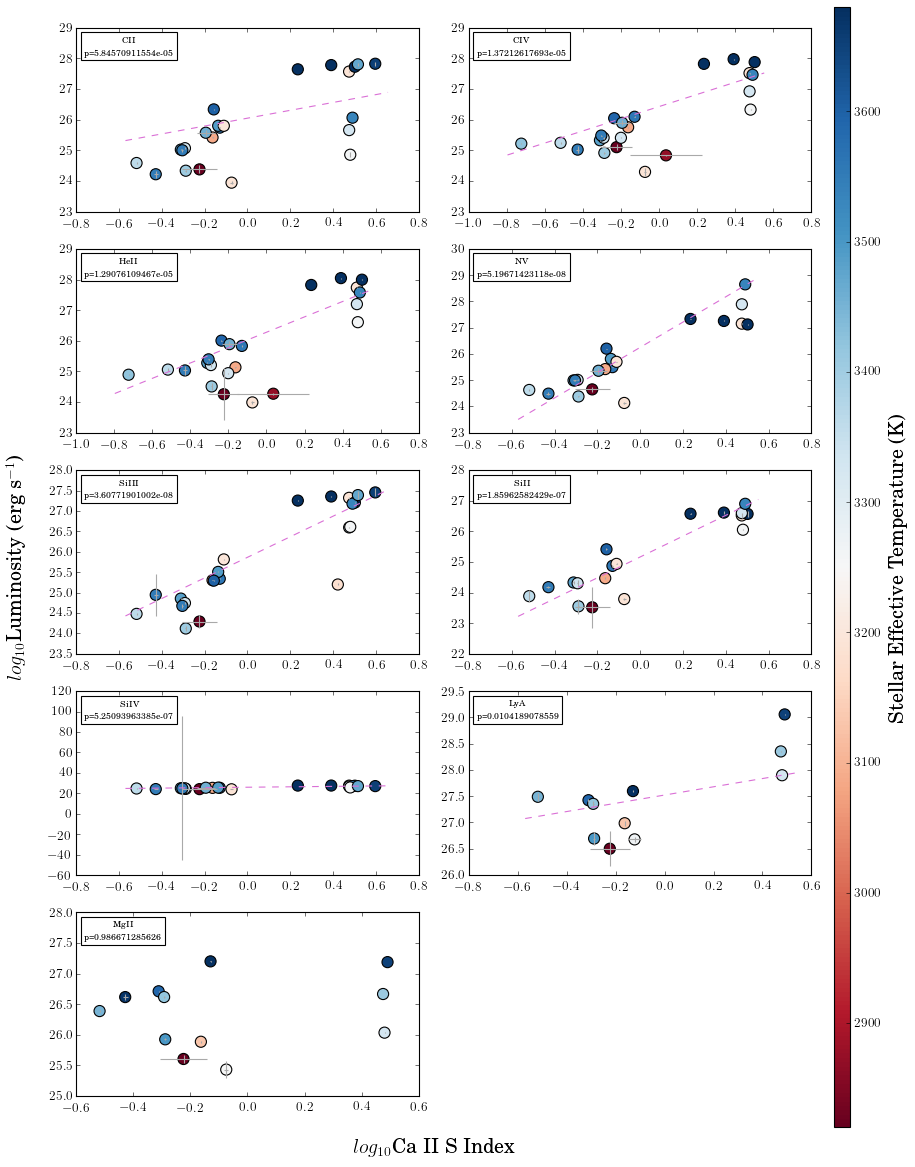

rhk_prime
CII 23
[2.0984474582520032, 25.834135520073978]
[  2.13799617  36.61010703]
CIV 22
[1.280622010653965, 25.999983672323228]
[  1.85192702  35.66093352]
HeII 22
[1.4123321232754429, 25.850304941721845]
[  2.16901104  37.18864646]
NV 20
[2.5249785835728717, 25.834051860364571]
[  3.21101797  42.51713334]
SiIII 22
[1.8006354169039871, 25.859492977038453]
[  2.18034068  36.81050274]
SiII 18
[1.8887145478749794, 25.170323472884679]
[  2.19792571  36.53875807]
SiIV 21
[1.9832906595301332, 25.755340988685436]
[  1.99095987  35.87911569]
LyA 11
0.0
[1.4976508185543176, 27.457269624306182]
[  1.59860698  35.98696991]
MgII 12
[1.0343157086820096, 26.355816454978484]
[  1.1418931   32.54884077]


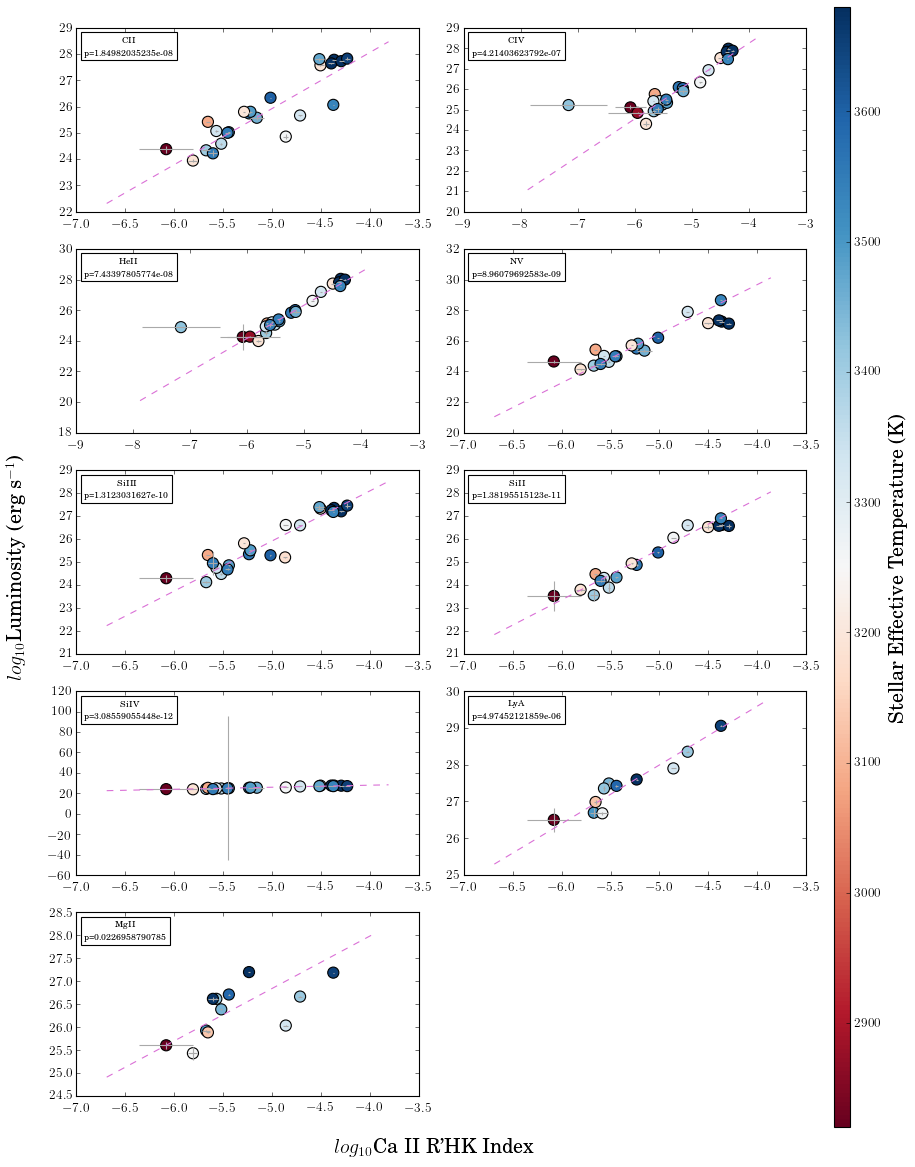

H_alpha
CII 25
CIV 25
HeII 23
NV 22
SiIII 24
SiII 20
SiIV 23
LyA 11
MgII 13


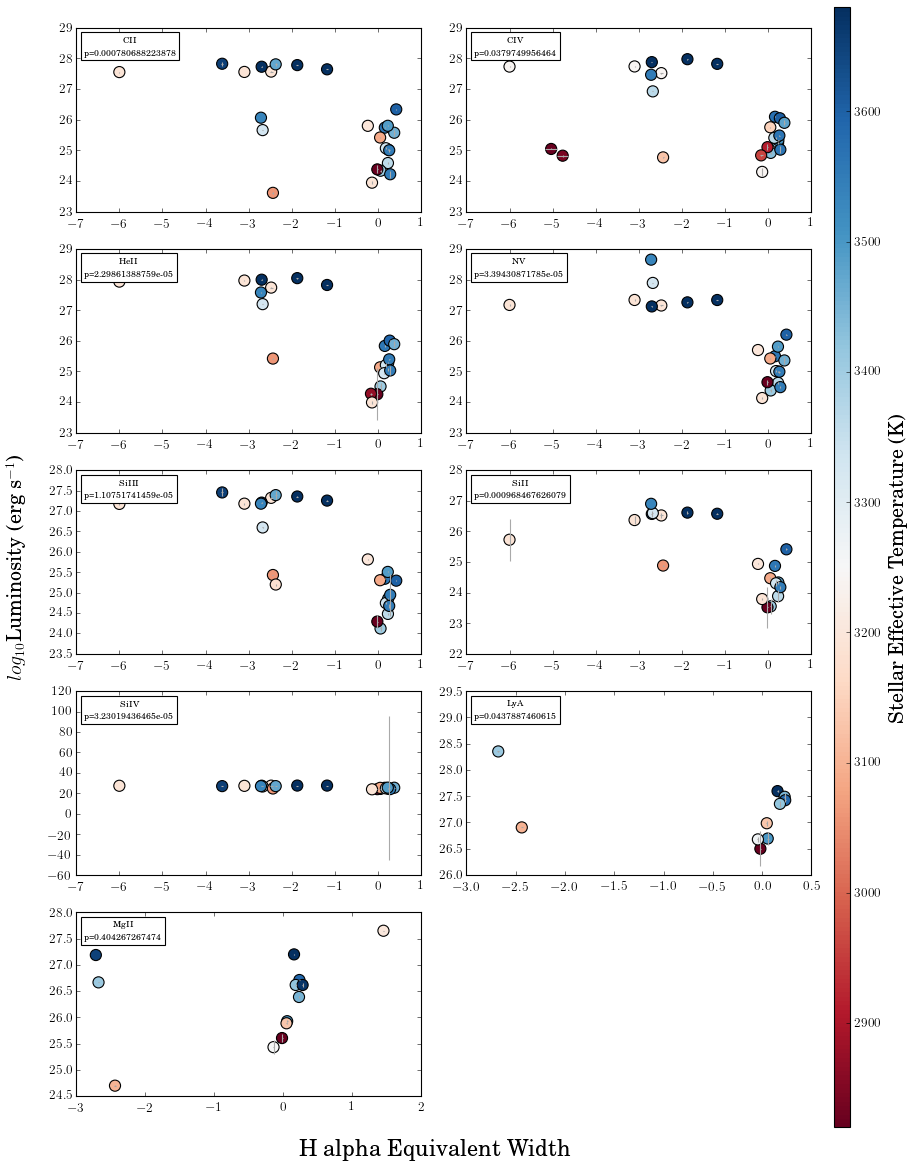

In [9]:
x_labels = ["Ca II S Index", "Ca II R'HK Index", "H alpha Equivalent Width"]

for k in range(len(optical_indicators)):
    data_sorted = data[np.argsort(data["%s" % optical_indicators[k]])]
    data_sorted = data[data["teff"]!=0]
    print(optical_indicators[k])

    #fig, axs = plt.subplots(5,2, figsize=(10, 14), facecolor='w', edgecolor='k') #, sharex=True)
    #axs = axs.ravel()
    
    fig = figure(figsize=(10, 14))
    #subplots_adjust(wspace=0.1,hspace=0.3)

    #stars = np.vectorize(star_names)
    
    #print(optical_indicators[k])

    for i in range(len(uv_lines)):
        
        #use iplot when not including EUV -- when including it, need to comment iplot out and add [i] to axs[i].plot again
        iplot = 520 + i + 1
        axs = fig.add_subplot(iplot)
        
        #bool_array = np.logical_and(data_sorted['%s' % optical_indicators[k]] != 0.0, data_sorted['%s_lum' % uv_lines[i]] != 0)
        #data_short_sorted = data_sorted[bool_array]
        #print(uv_lines[i], len(data_short_sorted["star"]))
        
        #print(data_short_sorted[optical_indicators])#, np.log10(data_short_sorted["%s_lum" % uv_lines[i]]))
        
        if optical_indicators[k]!="H_alpha":
            bool_array = np.logical_and(data_sorted['%s' % optical_indicators[k]] > 0.0, data_sorted['%s_lum' % uv_lines[i]] != 0)
            data_short_sorted = data_sorted[bool_array]
            print(uv_lines[i], len(data_short_sorted["star"]))
            x = data_short_sorted["log_%s" % optical_indicators[k]] #np.log10(data_short_sorted[optical_indicators[k]])
            y = np.log10(data_short_sorted['%s_lum' % uv_lines[i]])
            x_err = data_short_sorted["log_%s_err" % optical_indicators[k]]
            y_err = np.array(0.434 * data_short_sorted["%s_lum_err" % uv_lines[i]]) / data_short_sorted["%s_lum" % uv_lines[i]]
            #x_err = np.sqrt((data_short_sorted['%s_err' % optical_indicators[k]])**2 * (np.log10(math.e) / data_short_sorted['%s' % optical_indicators[k]])**2)
            #y_err = np.sqrt((data_short_sorted['%s_lum_err' % uv_lines[i]])**2 * (np.log10(math.e) / data_short_sorted['%s_lum' % uv_lines[i]])**2)
            
            #In case fluxes listed with error value of 0 (messes with the fitting:)
            y_err_new = []
            for value in y_err:
                if value == 0:
                    print(value)
                    value = 1e-29
                    y_err_new.append(value)
                else:
                    y_err_new.append(value)
            
        else:
            bool_array = np.logical_and(data_sorted['%s' % optical_indicators[k]] != 0.0, data_sorted['%s_lum' % uv_lines[i]] != 0)
            data_short_sorted = data_sorted[bool_array]
            print(uv_lines[i], len(data_short_sorted["star"]))
            x = np.array(data_short_sorted[optical_indicators[k]])
            y = np.log10(data_short_sorted['%s_lum' % uv_lines[i]])
            x_err = data_short_sorted["%s_err" % optical_indicators[k]]
            y_err_new = np.array(0.434 * data_short_sorted["%s_lum_err" % uv_lines[i]]) / data_short_sorted["%s_lum" % uv_lines[i]]
            #y_err =
            #print(np.vstack((np.array(x),np.array(y))))
            #print(x[0], y[0])
            #x_err = data_short_sorted["%s_err" % optical_indicators[k]]
            #y_err = np.sqrt((data_short_sorted['%s_lum_err' % uv_lines[i]])**2 * (np.log10(math.e) / data_short_sorted['%s_lum' % uv_lines[i]])**2)
            #axs.set_xlim(-20,2)
                
        pearson = pearsonr(x,y)
        string = uv_lines[i] + "\n" + "$p = $" + str(pearson[1])#[:6]
        #print(pearson)
            
        #axs[i].set_axis_off()
        im = axs.scatter(x, y, marker='o', s=100, c=data_short_sorted['teff'], cmap='RdBu', label="p=%s" % str(pearson[1])) # s=200*data_short_sorted['radius'],
        axs.errorbar(x, y, xerr=x_err, yerr= y_err_new, linestyle="None", markeredgewidth=0, c="darkgrey", label=None) #yerr=y_err, 

        #axs.text(np.min(x)-0.03, np.max(y)+.1, string)
        #print(x[1])
        #axs.set_xlim(np.min(x)-abs(np.min(x))*0.1,1)
        #axs.set_ylim(np.min(y)-abs(np.min(y))*0.1,np.max(y)+abs(np.max(y))*0.1)

        """for j, txt in enumerate(data_short_sorted["star"]):
            if txt[:5] == "2MASS":
                txt = "2M" + txt[-8:]
                axs.annotate(txt, xy=(x[j]+.01,y[j]+.05), fontsize=8)
            else:
                axs.annotate(txt, xy=(x[j]+.01,y[j]+.05), fontsize=8)"""
        
        #print(y_err)
        
        if optical_indicators[k]!="H_alpha":
            if float(pearson[1]) < 0.05:
                linear = scipy.odr.Model(linear_regression)
                mydata = scipy.odr.RealData(x, y, sx=x_err, sy=y_err_new)
                myodr = scipy.odr.ODR(mydata, linear, beta0=[(max(y)-min(y))/(max(x)-min(x)), np.mean(y)])
                myoutput = myodr.run()
                #myoutput.pprint()
                beta = myoutput.beta
                
                beta0=[(max(y)-min(y))/(max(x)-min(x)), np.mean(y)]
                print(beta0)
                print(beta)

                intercept = beta[1]
                slope = beta[0]

                x_range = np.linspace(np.min(x)-abs(np.min(x))*0.1,np.max(x)+abs(np.max(x))*0.1,100)
                y_fit = np.array([linear_regression(beta,value) for value in x_range])
                y_fit_short = np.array(linear_regression(beta,x))
                stddev_fit = np.std(y-y_fit_short)
                #print(uv_lines[i], stddev_fit)
                axs.plot(x_range, y_fit, linestyle="--", c="orchid")
        else:
            linear = scipy.odr.Model(linear_regression)
            mydata = scipy.odr.RealData(x[x<-0.75], y[x<-0.75], sx=x_err, sy=y_err_new)
            myodr = scipy.odr.ODR(mydata, linear, beta0=[(max(y[x<-0.75])-min(y[x<-0.75]))/(max(x[x<-0.75])-min(x[x<-0.75])), np.mean(y[x<-0.75])])
            myoutput = myodr.run()
            #myoutput.pprint()
            beta = myoutput.beta

            intercept = beta[1]
            slope = beta[0]

            x_range = np.linspace(np.min(x[x<-0.75])-abs(np.min(x[x<-0.75]))*0.1,np.max(x[x<-0.75])+abs(np.max(x[x<-0.75]))*0.1,100)
            y_fit = np.array([linear_regression(beta,value) for value in x_range])
            y_fit_short = np.array(linear_regression(beta,x[x<-0.75]))
            stddev_fit = np.std(y[x<-0.75]-y_fit_short)
            #print(uv_lines[i], stddev_fit)
            #axs.plot(x_range, y_fit, linestyle="--", c="orchid")
        
        lowess = sm.nonparametric.lowess
        z = lowess(y, x, frac=2./3)
        #axs.plot(z[:,0], z[:,1], linestyle="--", c="orchid")
        #print(z)
            
        #axs.set_ylim(20,30)
        legend = axs.legend(loc="upper left", title='%s' % uv_lines[i], fontsize=8, handlelength=0, handletextpad=0)
        for item in legend.legendHandles:
            item.set_visible(False)
        legend.get_title().set_fontsize('8')

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)

    cb_ax = fig.add_axes([1,0.00,0.02,1])
    cbar = fig.colorbar(im, cax=cb_ax)

    if optical_indicators[k]!="H_alpha":
        fig.text(0.5, -0.02, '$log_{10}$%s' % x_labels[k], ha='center', va='center', fontsize=18)
        fig.text(-0.02, 0.5, '$log_{10}$Luminosity (erg s$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=18)
        fig.text(1.08, 0.5, 'Stellar Effective Temperature (K)', ha='center', va='center', rotation='vertical', fontsize=18)
        #fig.colorbar(sc)
        #plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=None, hspace=None)
        fig.tight_layout()
        plt.savefig("Graphs/regs_%s_vs_lum.png" % (optical_indicators[k]), bbox_inches="tight")
        plt.show()
    else:
        fig.text(0.5, -0.02, '%s' % x_labels[k], ha='center', va='center', fontsize=20)
        fig.text(-0.02, 0.5, '$log_{10}$Luminosity (erg s$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=18)
        fig.text(1.08, 0.5, 'Stellar Effective Temperature (K)', ha='center', va='center', rotation='vertical', fontsize=18)
        #fig.colorbar(sc)
        #plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=None, hspace=None)
        fig.tight_layout()
        plt.savefig("Graphs/regs_%s_vs_lum.png" % (optical_indicators[k]), bbox_inches="tight")
        plt.show()

## Surface Flux Plots WITH REGRESSIONS AND ERROR BARS

s
CII 22
[2.5348239915952373, 3.6602941333587484]
[ 3.46192935  3.48143289]
CIV 21
[1.9710739685849612, 3.9185868586773229]
[ 2.24308205  3.99322221]
HeII 21
[2.2796760226788626, 3.7659413182693378]
[ 2.88143114  3.86181688]
NV 19
[3.4420273047842218, 3.7033257908235733]
[ 3.56380837  3.7890979 ]
SiIII 21
[2.136132909012765, 3.7205080284405172]
[ 2.34852769  3.51608496]
SiII 18
[2.6960197628038922, 3.024401926461314]
[ 2.76725958  2.96991585]
SiIV 20
[2.3148785456160077, 3.5533728775789242]
[ 2.59448184  3.37120703]
LyA 11
0.0
[1.4672777057708901, 5.4841962634861714]
[ 1.49841402  5.56619365]
MgII 13


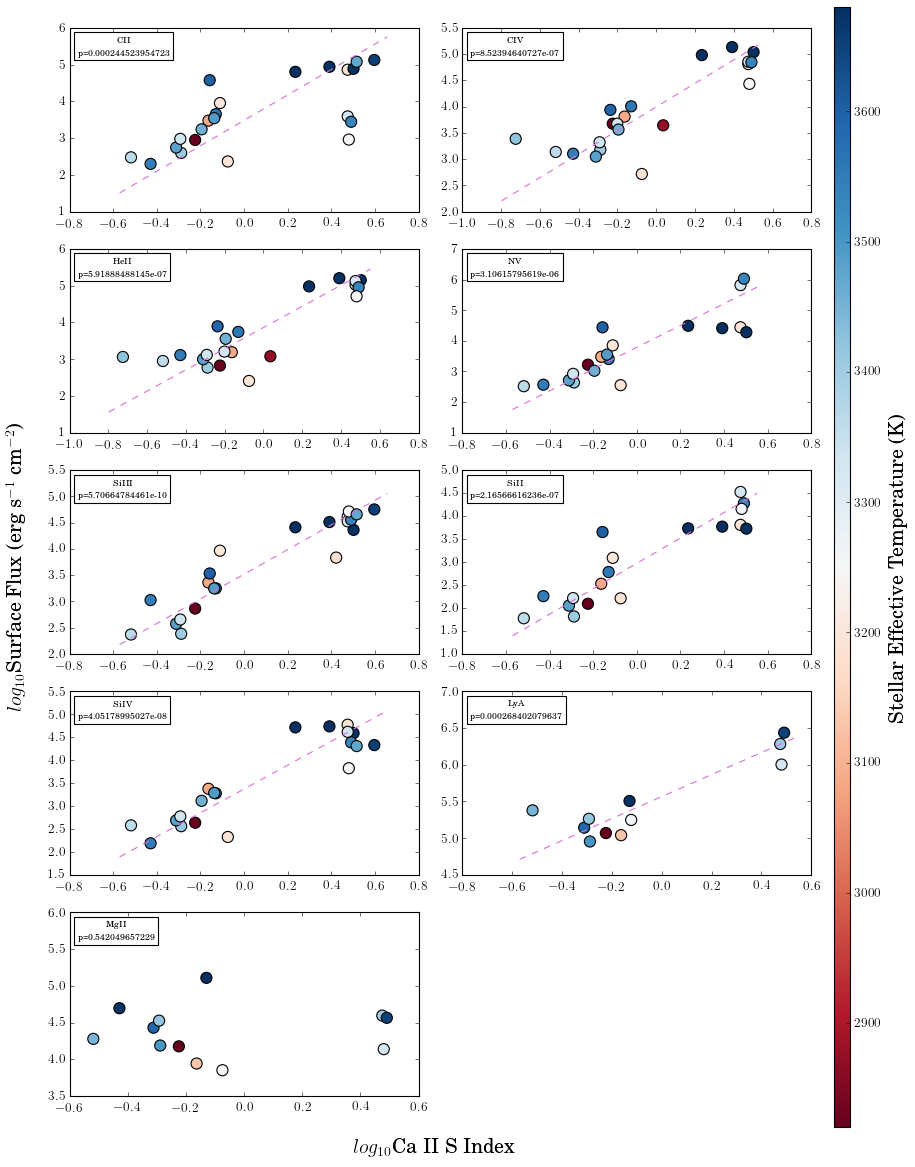

rhk_prime
CII 22
[1.5276035653786826, 3.6602941333587484]
[  1.89162186  13.24522271]
CIV 21
[0.84124642381217962, 3.9185868586773229]
[ 1.08805829  9.67875262]
HeII 21
[0.97295653643365687, 3.7659413182693378]
[  1.42368169  11.30289276]
NV 19
[1.9619210250313082, 3.7033257908235733]
[  2.1753752   14.90924001]
SiIII 21
[1.2873336605422587, 3.7205080284405172]
[  1.60898582  11.79450991]
SiII 18
[1.5367042118442649, 3.024401926461314]
[  1.71296215  11.81373336]
SiIV 20
[1.3950541463339197, 3.5533728775789242]
[  1.59865524  11.64074381]
LyA 11
0.0
[0.86656119710989421, 5.4841962634861714]
[  1.04234524  11.04534857]
MgII 12


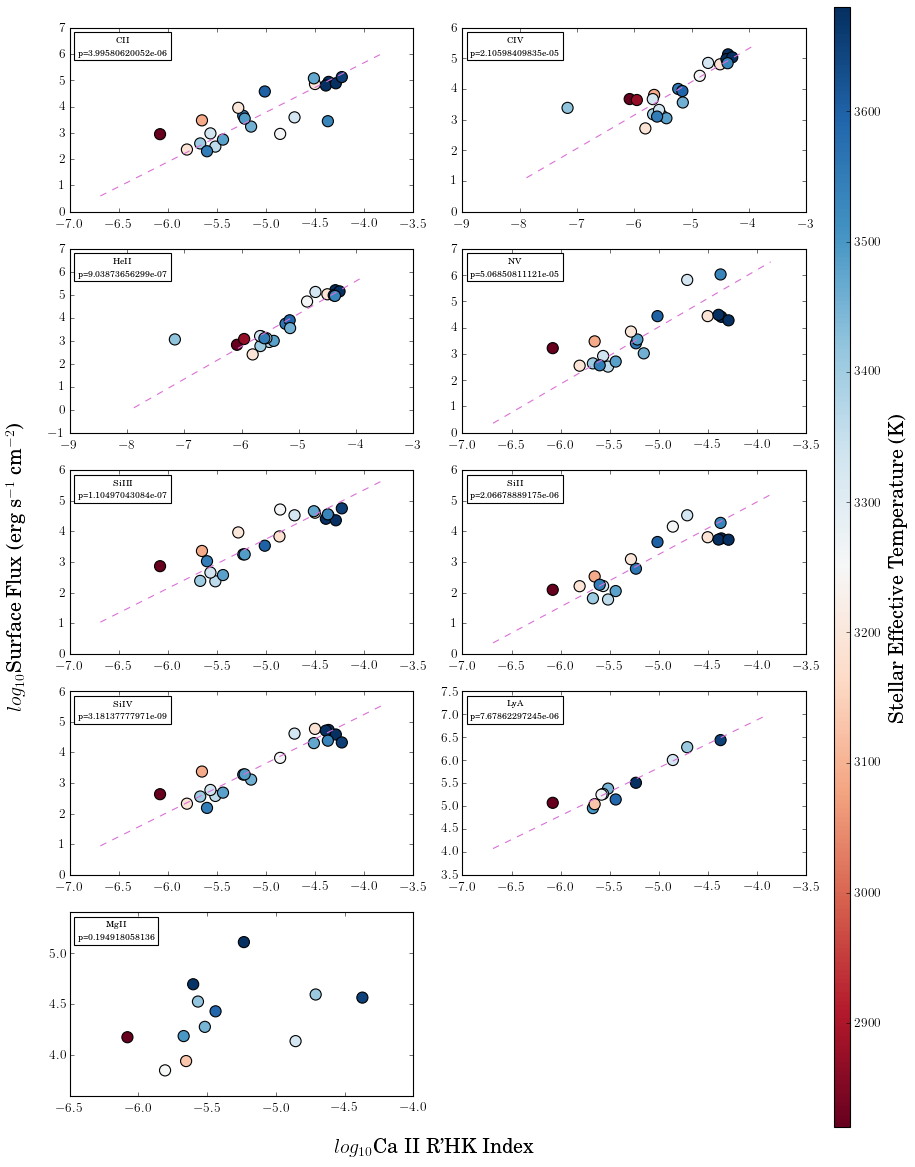

H_alpha
CII 24
CIV 24
HeII 22
NV 21
SiIII 23
SiII 20
SiIV 22
LyA 11
MgII 13


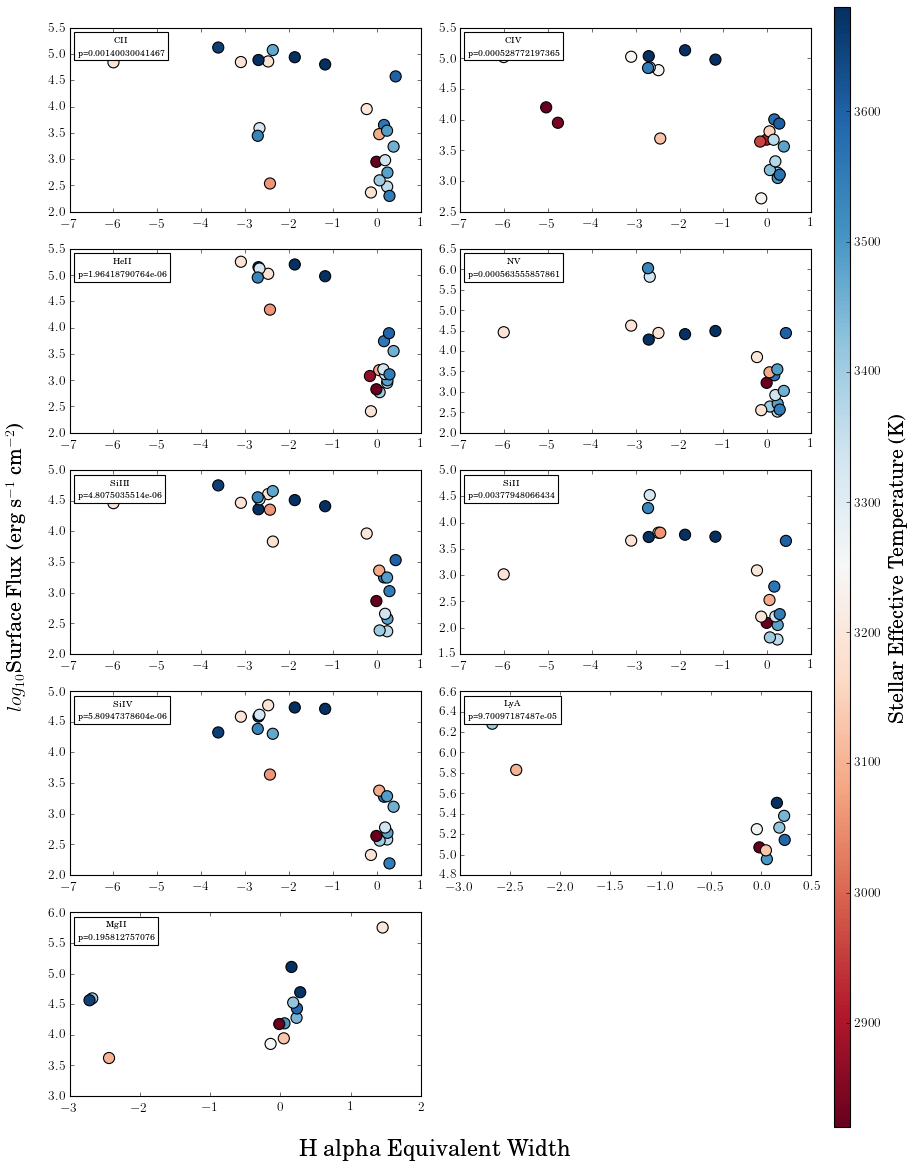

In [11]:
x_labels = ["Ca II S Index", "Ca II R'HK Index", "H alpha Equivalent Width"]

for k in range(len(optical_indicators)):
    data_sorted = data[np.argsort(data["%s" % optical_indicators[k]])]
    data_sorted = data[data["teff"]!=0]
    print(optical_indicators[k])

    #fig, axs = plt.subplots(5,2, figsize=(10, 14), facecolor='w', edgecolor='k') #, sharex=True)
    #axs = axs.ravel()
    
    fig = figure(figsize=(10, 14))
    #subplots_adjust(wspace=0.1,hspace=0.3)

    #stars = np.vectorize(star_names)
    
    #print(optical_indicators[k])

    for i in range(len(uv_lines)):
        
        #use iplot when not including EUV -- when including it, need to comment iplot out and add [i] to axs[i].plot again
        iplot = 520 + i + 1
        axs = fig.add_subplot(iplot)
        
        #bool_array = np.logical_and(data_sorted['%s' % optical_indicators[k]] != 0.0, data_sorted['%s_lum' % uv_lines[i]] != 0)
        #data_short_sorted = data_sorted[bool_array]
        #print(uv_lines[i], len(data_short_sorted["star"]))
        
        #print(data_short_sorted[optical_indicators])#, np.log10(data_short_sorted["%s_lum" % uv_lines[i]]))
        
        if optical_indicators[k]!="H_alpha":
            bool_array = np.logical_and(data_sorted['%s' % optical_indicators[k]] > 0.0, data_sorted['%s_surface_flux' % uv_lines[i]] != 0)
            data_short_sorted = data_sorted[bool_array]
            print(uv_lines[i], len(data_short_sorted["star"]))
            x = data_short_sorted["log_%s" % optical_indicators[k]] #np.log10(data_short_sorted[optical_indicators[k]])
            y = np.log10(data_short_sorted['%s_surface_flux' % uv_lines[i]])
            x_err = data_short_sorted["log_%s_err" % optical_indicators[k]]
            y_err = np.array(0.434 * data_short_sorted["%s_surface_flux_err" % uv_lines[i]]) / data_short_sorted["%s_surface_flux" % uv_lines[i]]
            #x_err = np.sqrt((data_short_sorted['%s_err' % optical_indicators[k]])**2 * (np.log10(math.e) / data_short_sorted['%s' % optical_indicators[k]])**2)
            #y_err = np.sqrt((data_short_sorted['%s_lum_err' % uv_lines[i]])**2 * (np.log10(math.e) / data_short_sorted['%s_lum' % uv_lines[i]])**2)
            
            #In case fluxes listed with error value of 0 (messes with the fitting:)
            y_err_new = []
            for value in y_err:
                if value == 0:
                    print(value)
                    value = 1e-29
                    y_err_new.append(value)
                else:
                    y_err_new.append(value)
            
        else:
            bool_array = np.logical_and(data_sorted['%s' % optical_indicators[k]] != 0.0, data_sorted['%s_surface_flux' % uv_lines[i]] != 0)
            data_short_sorted = data_sorted[bool_array]
            print(uv_lines[i], len(data_short_sorted["star"]))
            x = np.array(data_short_sorted[optical_indicators[k]])
            y = np.log10(data_short_sorted['%s_surface_flux' % uv_lines[i]])
            x_err = data_short_sorted["%s_err" % optical_indicators[k]]
            y_err_new = np.array(0.434 * data_short_sorted["%s_surface_flux_err" % uv_lines[i]]) / data_short_sorted["%s_surface_flux" % uv_lines[i]]
            #y_err =
            #print(np.vstack((np.array(x),np.array(y))))
            #print(x[0], y[0])
            #x_err = data_short_sorted["%s_err" % optical_indicators[k]]
            #y_err = np.sqrt((data_short_sorted['%s_lum_err' % uv_lines[i]])**2 * (np.log10(math.e) / data_short_sorted['%s_lum' % uv_lines[i]])**2)
            #axs.set_xlim(-20,2)
                
        pearson = pearsonr(x,y)
        string = uv_lines[i] + "\n" + "$p = $" + str(pearson[1])#[:6]
        #print(pearson)
            
        #axs[i].set_axis_off()
        im = axs.scatter(x, y, marker='o', s=100, c=data_short_sorted['teff'], cmap='RdBu', label="p=%s" % str(pearson[1])) # s=200*data_short_sorted['radius'],
        #axs.errorbar(x, y, xerr=x_err, yerr= y_err_new, linestyle="None", markeredgewidth=0, c="darkgrey", label=None) #yerr=y_err, 

        #axs.text(np.min(x)-0.03, np.max(y)+.1, string)
        #print(x[1])
        #axs.set_xlim(np.min(x)-abs(np.min(x))*0.1,1)
        #axs.set_ylim(np.min(y)-abs(np.min(y))*0.1,np.max(y)+abs(np.max(y))*0.1)

        """for j, txt in enumerate(data_short_sorted["star"]):
            if txt[:5] == "2MASS":
                txt = "2M" + txt[-8:]
                axs.annotate(txt, xy=(x[j]+.01,y[j]+.05), fontsize=8)
            else:
                axs.annotate(txt, xy=(x[j]+.01,y[j]+.05), fontsize=8)"""
        
        #print(y_err)
        
        if optical_indicators[k]!="H_alpha":
            if float(pearson[1]) < 0.05:
                linear = scipy.odr.Model(linear_regression)
                mydata = scipy.odr.RealData(x, y) #, sx=x_err, sy=y_err_new)
                myodr = scipy.odr.ODR(mydata, linear, beta0=[(max(y)-min(y))/(max(x)-min(x)), np.mean(y)])
                myoutput = myodr.run()
                #myoutput.pprint()
                beta = myoutput.beta
                
                beta0=[(max(y)-min(y))/(max(x)-min(x)), np.mean(y)]
                print(beta0)
                print(beta)

                intercept = beta[1]
                slope = beta[0]

                x_range = np.linspace(np.min(x)-abs(np.min(x))*0.1,np.max(x)+abs(np.max(x))*0.1,100)
                y_fit = np.array([linear_regression(beta,value) for value in x_range])
                y_fit_short = np.array(linear_regression(beta,x))
                stddev_fit = np.std(y-y_fit_short)
                #print(uv_lines[i], stddev_fit)
                axs.plot(x_range, y_fit, linestyle="--", c="orchid")
        else:
            linear = scipy.odr.Model(linear_regression)
            mydata = scipy.odr.RealData(x[x<-0.75], y[x<-0.75]) #, sx=x_err, sy=y_err_new)
            myodr = scipy.odr.ODR(mydata, linear, beta0=[(max(y[x<-0.75])-min(y[x<-0.75]))/(max(x[x<-0.75])-min(x[x<-0.75])), np.mean(y[x<-0.75])])
            myoutput = myodr.run()
            #myoutput.pprint()
            beta = myoutput.beta

            intercept = beta[1]
            slope = beta[0]

            x_range = np.linspace(np.min(x[x<-0.75])-abs(np.min(x[x<-0.75]))*0.1,np.max(x[x<-0.75])+abs(np.max(x[x<-0.75]))*0.1,100)
            y_fit = np.array([linear_regression(beta,value) for value in x_range])
            y_fit_short = np.array(linear_regression(beta,x[x<-0.75]))
            stddev_fit = np.std(y[x<-0.75]-y_fit_short)
            #print(uv_lines[i], stddev_fit)
            #axs.plot(x_range, y_fit, linestyle="--", c="orchid")
        
        lowess = sm.nonparametric.lowess
        z = lowess(y, x, frac=2./3)
        #axs.plot(z[:,0], z[:,1], linestyle="--", c="orchid")
        #print(z)
            
        #axs.set_ylim(20,30)
        legend = axs.legend(loc="upper left", title='%s' % uv_lines[i], fontsize=8, handlelength=0, handletextpad=0)
        for item in legend.legendHandles:
            item.set_visible(False)
        legend.get_title().set_fontsize('8')

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)

    cb_ax = fig.add_axes([1,0.00,0.02,1])
    cbar = fig.colorbar(im, cax=cb_ax)

    if optical_indicators[k]!="H_alpha":
        fig.text(0.5, -0.02, '$log_{10}$%s' % x_labels[k], ha='center', va='center', fontsize=18)
        fig.text(-0.02, 0.5, '$log_{10}$Surface Flux (erg s$^{-1}$ cm$^{-2}$)', ha='center', va='center', rotation='vertical', fontsize=18)
        fig.text(1.08, 0.5, 'Stellar Effective Temperature (K)', ha='center', va='center', rotation='vertical', fontsize=18)
        #fig.colorbar(sc)
        #plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=None, hspace=None)
        fig.tight_layout()
        plt.savefig("Graphs/regs_%s_vs_surface_flux.png" % (optical_indicators[k]), bbox_inches="tight")
        plt.show()
    else:
        fig.text(0.5, -0.02, '%s' % x_labels[k], ha='center', va='center', fontsize=20)
        fig.text(-0.02, 0.5, '$log_{10}$Surface Flux (erg s$^{-1}$ cm$^{-2}$)', ha='center', va='center', rotation='vertical', fontsize=18)
        fig.text(1.08, 0.5, 'Stellar Effective Temperature (K)', ha='center', va='center', rotation='vertical', fontsize=18)
        #fig.colorbar(sc)
        #plt.subplots_adjust(left=0.5, bottom=None, right=None, top=None, wspace=None, hspace=None)
        fig.tight_layout()
        plt.savefig("Graphs/regs_%s_vs_surface_flux.png" % (optical_indicators[k]), bbox_inches="tight")
        plt.show()

# EXTRA CODE PRACTICE

In [140]:
print(y)

LyA_surface_flux
----------------
    5.5063635677
   5.37898884288
   4.95485530484
   5.07020404244
   5.14308435896
   5.04101315016
   5.26371793273
   6.40712154796
   6.47511530289
   6.30849763771
   5.04465222297
   5.80238365048
   6.55489995217
   6.28170498943
     6.435584153
   5.82893675931
   5.24830807744


In [106]:
#print(0.434 * np.nan_to_num(np.array(data_short_sorted["%s_lum_err" % uv_lines[i]])) / data_short_sorted["%s_lum" % uv_lines[i]])
print(y_err)
beta0=[(max(y)-min(y))/(max(x)-min(x)), np.mean(y)]
print(beta)
print(beta0)
print(x_range)
print(y_fit)
print(len(x))
#plt.scatter(x,y)
#plt.errorbar(x,y, xerr=x_err, linestyle="None", markeredgewidth=0)
txt="2MASS0123456789"
print(txt[-8:])
print(data.dtype.names)

     LyA_lum     
-----------------
  0.0222564102564
  0.0751153846154
   0.118363636364
   0.333846153846
  0.0274105263158
  0.0445128205128
            0.062
3.85864902935e-29
4.02684240215e-30
1.52083211139e-29
7.43777893571e-29
3.12158550211e-29
5.72704828294e-30
  0.0107558859975
  0.0162242990654
              0.0
           0.0434
[  0.38264789  27.8415767 ]
[0.3733252073055886, 27.727289827291198]
[-7.28206514 -7.21752858 -7.15299203 -7.08845547 -7.02391892 -6.95938236
 -6.89484581 -6.83030926 -6.7657727  -6.70123615 -6.63669959 -6.57216304
 -6.50762648 -6.44308993 -6.37855337 -6.31401682 -6.24948026 -6.18494371
 -6.12040715 -6.0558706  -5.99133404 -5.92679749 -5.86226094 -5.79772438
 -5.73318783 -5.66865127 -5.60411472 -5.53957816 -5.47504161 -5.41050505
 -5.3459685  -5.28143194 -5.21689539 -5.15235883 -5.08782228 -5.02328572
 -4.95874917 -4.89421262 -4.82967606 -4.76513951 -4.70060295 -4.6360664
 -4.57152984 -4.50699329 -4.44245673 -4.37792018 -4.31338362 -4.24884707
 -4.18

0.0
0.0
[0.022256410256410255, 0.075115384615384612, 0.11836363636363638, 0.33384615384615385, 0.027410526315789472, 0.04451282051282051, 0.062000000000000006, 6.8646070416132841e-29, 4.0268424021463289e-30, 1.5208321113939452e-29, 7.4377789357084063e-29, 3.1215855021111446e-29, 5.7270482829391849e-30, 0.010755885997521685, 0.016224299065420559, 1e-29, 1e-29, 0.043400000000000001]
   LyA_lum_err   
-----------------
2.02853416757e+26
5.33546180535e+26
1.34664997415e+26
2.42732328946e+26
 1.6761635851e+26
9.90841232678e+25
3.23201422467e+26
               --
               --
               --
               --
               --
               --
5.58721195035e+26
4.27410212203e+27
              0.0
              0.0
4.75526813115e+25
     LyA_lum     
-----------------
  0.0222564102564
  0.0751153846154
   0.118363636364
   0.333846153846
  0.0274105263158
  0.0445128205128
            0.062
6.86460704161e-29
4.02684240215e-30
1.52083211139e-29
7.43777893571e-29
3.12158550211e-29
5.72

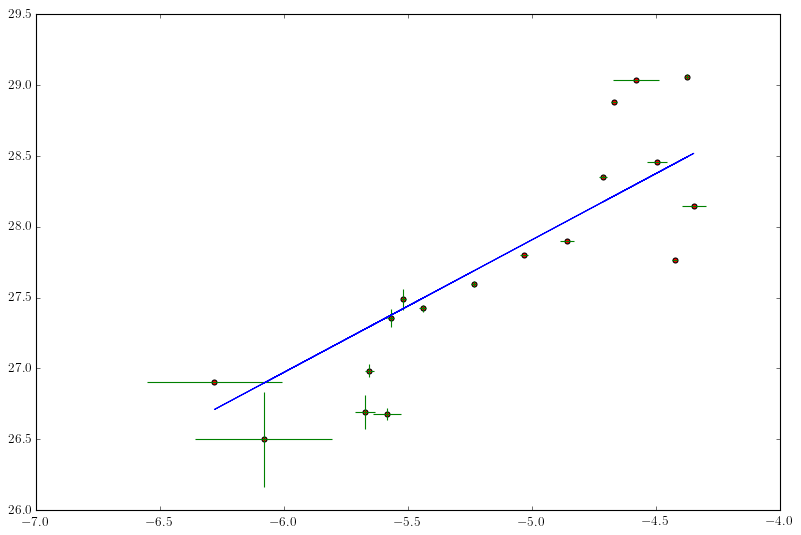

In [134]:
parameter = "rhk_prime"
line = "LyA"

data_sorted = data[np.argsort(data[parameter])]
data_sorted = data[data["teff"]!=0]
bool_array = np.logical_and(data_sorted[parameter] != 0.0, data_sorted[line] != 0)
data_short_sorted = data_sorted[bool_array]

x = data_short_sorted["log_%s" % parameter] #np.log10(data_short_sorted[optical_indicators[k]])
y = np.log10(data_short_sorted['%s_lum' % line])
x_err = data_short_sorted["log_%s_err" % parameter]
y_err = np.array(0.434 * data_short_sorted["%s_lum_err" % line]) / data_short_sorted["%s_lum" % line]

y_err_new = []
for value in y_err:
    if value == 0:
        print(value)
        value = 1e-29
        y_err_new.append(value)
    else:
        y_err_new.append(value)

linear = scipy.odr.Model(linear_regression)
mydata = scipy.odr.RealData(x, y, sx=x_err, sy=y_err_new)
myodr = scipy.odr.ODR(mydata, linear, beta0=[(max(y)-min(y))/(max(x)-min(x)), np.mean(y)])
myoutput = myodr.run()
beta = myoutput.beta
#myoutput.pprint()

intercept = beta[1]
slope = beta[0]

y_fit = np.array([linear_regression(beta,value) for value in x])

print(y_err_new)
print(data_short_sorted["%s_lum_err" % line])
print(y_err)

plt.figure(figsize=(12,8))
#plt.errorbar(np.log(sigma), np.log(M_BH), xerr=sigma_err, yerr=[err_low, err_high], fmt="o")
plt.scatter(x,y, c="red")
plt.plot(x, y_fit)
plt.errorbar(x,y, xerr = x_err, yerr = y_err_new, linestyle="None", markeredgewidth=0)
plt.show()

In [133]:
#print(data_short_sorted["star"])
#print(pearson[1])
#data.dtype.names

In [155]:
data_sorted = data[np.argsort(data["rhk_prime"])]    

bool_array = np.logical_and(data_sorted["rhk_prime"] != 0.0, data_sorted['CIV_lum'] != 0)

data_short_sorted = data_sorted[bool_array]
#print(data_short_sorted["rhk_prime"])

x = np.log10(data_short_sorted["rhk_prime"])
y = np.log10(data_short_sorted['CIV_lum'])

#print(z)
#print(x)
#print(len(z[:,0]))
#print(len(x))

#plt.scatter(x, y, marker='o', s=100, alpha=0.5)

lowess = sm.nonparametric.lowess
z = lowess(y, x, frac=2./3, is_sorted=False, return_sorted=True)
#plt.plot(z[:,0], z[:,1])

/Users/katiemel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


107
23
[  1.10518230e+23   9.01948537e+22   7.33439505e+26   2.56050530e+27
   1.07058187e+27   4.86087440e+26   1.01830483e+27   2.68998411e+27
   3.03944330e+27   5.19885832e+24   1.08636698e+27   3.78340090e+27
   3.59415587e+27   8.07586600e+23   1.16268786e+24   2.09067500e+25
   1.99304196e+24   2.33281429e+25   7.33667229e+24   4.89083999e+24
   9.30270790e+24   2.81715510e+25   1.28718902e+24]


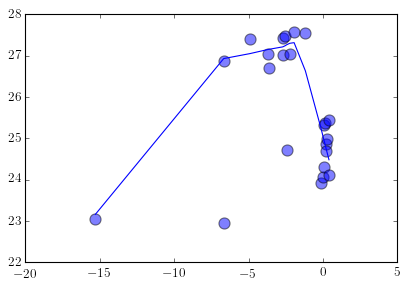

In [156]:
lowess = sm.nonparametric.lowess

parameter = "H_alpha"
line = "SiIV_lum"
print(len(data))

data_sorted = data[np.argsort(data[parameter])]    

bool_array = np.logical_and(data_sorted[parameter] != 0.0, data_sorted[line] != 0)

data_short_sorted = data_sorted[bool_array]
print(len(np.array(data_short_sorted[parameter])))
print(np.array(data_short_sorted[line]))

x = data_short_sorted[parameter]
y = np.log10(data_short_sorted[line])

z = lowess(y, x, frac=2./3, is_sorted=True, return_sorted=True)

plt.scatter(x, y, marker='o', s=100, alpha=0.5)
plt.plot(z[:,0], z[:,1])

In [ ]:

#print(z)
#print(x)
#print(len(z[:,0]))
#print(len(x))

plt.scatter(x, y, marker='o', s=100, alpha=0.5)
#plt.plot(z[:,0], z[:,1])

data_sorted = data[np.argsort(data["rhk_prime"])]    

bool_array = np.logical_and(data_sorted["rhk_prime"] > 0.0, data_sorted['SiIII_lum'] != 0)

data_short_sorted = data_sorted[bool_array]
print(np.array(data_short_sorted["rhk_prime"]))

x = np.log10(data_short_sorted["rhk_prime"])
y = np.log10(data_short_sorted['SiIII_lum'])

z = lowess(y, x, frac=2./3, is_sorted=True, return_sorted=True)

#print(z)
#print(x)
#print(len(z[:,0]))
#print(len(x))
